**Introduction**
<br>
<br>
This analysis will go through rescue data acquired from Calvin's Paws, a cat rescue that operates out of Raleigh, NC. It will be looking to perform exploratory analysis of possible factors from the datasets that could affect a cat's adoptability. The factors to include for exploratory analysis are breed, coloration, sex, age, and total medical cost versus how long a cats stayed in the rescue. In addition to factors for what affects how long a cat is in the rescue, an initial text analysis of comments in denied applications will be done to see what factors outside of a cat's control prevent it from being adopted - and therefore staying in the rescue longer.
<br>
<br>
A significant portion of the codebase for this analysis comes from the Thinkstats library, which can be found at https://github.com/AllenDowney/ThinkStats2. 

**Importing Packages and Written Functions Used for Analysis and Cleaning**

In [206]:
# Importing Packages and Loading Data
import thinkstats2
import thinkplot
import survival
import scatter
import hypothesis
import cumulative
import probability
import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt
from datetime import datetime
from collections import Counter

In [236]:
# Functions Written for Analysis

'''
The data being analyzed for this analysis will span from 2014-2023. There is more data in each of the datasets than that timespan, so we will need to
make sure that only those data are present. Luckily, each cat that has gone through Calvin's Paws is given a unique RescueID that contains a letter, a 
two digit year, and a three digit number. We will want to filter for RescueIDs that begin with F and the two digit years for 2014 through 2023. Each of
those will be fed into the function as a tag using a list of the tags.

The rescueid_cleaner function will do that filtering for us. To do that, we loop through each tag and check which lines in the dataframe contain the
tag. Those lines are then indexed for and concatenated with the df_out dataframe to make sure they are returned as part of the output.
'''
def rescueid_cleaner(df_in, tags):
    df_out = pd.DataFrame()
    for tag in tags:
        criterion = df_in['Rescue ID'].map(lambda x: x.startswith(tag))
        df_out = pd.concat([df_out, df_in[criterion]], ignore_index=True)
        
    return(df_out)

'''
The status_cleaner function is used to filter lines in the Adoptability Report Dataframe by line according the the cat's status. We only want cats that
have been adopted, so that will be the criterion used for filtering. It behaves the same was as the rescueid_cleaner function.
'''
def status_cleaner(df_in, status):
    df_out = pd.DataFrame()
    criterion = df_in['Status'].map(lambda x: x.startswith(status))
    df_out = pd.concat([df_out, df_in[criterion]], ignore_index=True)
    return(df_out)


'''
The times in the reports used for this analysis were imported as strings instead of time objects. They will need to be converted if they can be used to
create other variables that depend on differences in time. The gen_time_converter and created_converter functions will take a set of columns and
convert their entries to time objects by iterating through the columns. For each column given, a for loop will visit each entry and convert it to a
datetime object.
'''
def gen_time_converter(column):
    format = '%m/%d/%Y'
    i = 0
    working_list =[]
    while i < len(column):      
        date_str = column[i]
        work_object = datetime.strptime(date_str, format).date()
        working_list.append(work_object)
        i += 1
    series = pd.Series(working_list)
    return(series)


def created_converter(column):  # Used specifically for the Created columns since they have times. 
    format = '%m/%d/%Y %I:%M %p'
    i = 0
    working_list = []
    while i < len(column):
        date_str = column[i]
        work_object = datetime.strptime(date_str, format).date()
        working_list.append(work_object)
        i += 1
    series = pd.Series(working_list)
    return(series)


'''
Creating the Residency variable required subtracting time between two pandas series. That is easy enough but it leaves each entry in the column as a
datetime object. For ease of analysis, we would prefer to have integers of the number of days. So we'll use a for loop to convert each entry in the 
column from datetime to int.
'''
def datetime_cleaner(column):
    i = 0
    working_list = []
    while i < len(column):
        work_object = int(column[i].total_seconds()/86400)
        working_list.append(work_object)
        i += 1
    series = pd.Series(working_list)
    return(series)
    

'''
The Cost and Fees Paid columns of the Cost Report have extra characters in them, each having $&nbsp;. We would also like to make sure that they are kept
in the dataframe as float values. We will want to remove those extra characters and
'''
def cost_cleaner(column):
    i = 0
    working_list = []
    while i < len(column):
        work_object = column[i]
        work_object = work_object[7:]
        work_object = float(work_object)
        working_list.append(work_object)
        i += 1
    series = pd.Series(working_list)
    return(series)
   

'''
To analyze the data without outliers and the outliers themselves, we need to separate the data. This will be done using z-scores. We want to keep the
data though, so we will have the filtered data and the outliers themselves returned by the function. The filtering will be done in a similar manner as
the previous functions that performed logical indexing and filtering of the input dataframe.
'''
def adoptability_outliers(df_in):
    adopt_out = pd.DataFrame()
    adopt_outliers = pd.DataFrame()
    outlier_criterion = df_in['Residency z'].map(lambda x: abs(x) >= 3)
    adopt_criterion = df_in['Residency z'].map(lambda x: abs(x) < 3)
    adopt_out = pd.concat([adopt_out, df_in[adopt_criterion]], ignore_index=True)
    adopt_outliers = pd.concat([adopt_outliers, df_in[outlier_criterion]], ignore_index=True)
    return(adopt_out, adopt_outliers)


'''
To analyze the cost data without outliers, we will have to filter them out. We will also want to keep the outliers in a dataset for further analysis
later.
'''
def cost_outliers(df_in):
    cost_out = pd.DataFrame()
    cost_outliers = pd.DataFrame()
    cost_outlier_criterion = df_in['Cost z'].map(lambda x: abs(x) >= 3)
    length_outlier_criterion = df_in['Length z'].map(lambda x: abs(x) >= 3)
    cost_outliers = pd.concat([cost_outliers, df_in[cost_outlier_criterion]], ignore_index=True)
    cost_outliers = pd.concat([cost_outliers, df_in[length_outlier_criterion]], ignore_index=True)
    cost_criterion = df_in['Cost z'].map(lambda x: abs(x) < 3) & df_in['Length z'].map(lambda x: abs(x) < 3)
    cost_out = pd.concat([cost_out, df_in[cost_criterion]], ignore_index=True)
    return(cost_out, cost_outliers)


'''
As part of the breed analysis, we will need to compare the domestic and non-domestic named breeds. It will be easier to create new dataframes for each
group for indexing and analysis.
'''
def domestics_splitter(df_in):
    domestics = pd.DataFrame()
    nondomestics = pd.DataFrame()
    domestics_criteria = df_in['Primary Breed'].map(lambda x: x.startswith('Domestic'))
    nondomestic_criteria = df_in['Primary Breed'].map(lambda x: not x.startswith('Domestic'))
    domestics = pd.concat([domestics, df_in[domestics_criteria]], ignore_index=True)
    nondomestics = pd.concat([nondomestics, df_in[nondomestic_criteria]], ignore_index=True)
    return(domestics, nondomestics)


'''
Splitting the adoptability_filt dataframe by sex of the cat will be done for analysis. 
'''
def sex_splitter(df_in):
    males = pd.DataFrame()
    females = pd.DataFrame()
    male_criteria = df_in['Sex'].map(lambda x: x == "Male")
    female_criteria = df_in['Sex'].map(lambda x: x == "Female")
    males = pd.concat([males, df_in[male_criteria]], ignore_index=True)
    females = pd.concat([females, df_in[female_criteria]])
    return(males, females)


'''
The first letter of a cat's name may have an impact on adoptability. So we can create a new series and have it appended to the dataframe to check that.
'''
def first_letter(column):
    i = 0
    working_list = []
    while i < len(column):
        work_object = column[i]
        work_object = work_object[0]
        working_list.append(work_object)
        i += 1
    series = pd.Series(working_list)
    return(series)


'''
Function to load and do initial cleaning of the Adoptability Report
'''
def adoptability_report_loader():
    adopt_report = pd.read_csv("Adoptability Report v2.csv")
    adopt_report = adopt_report.drop(columns="Euthanasia Date")
    adopt_report = status_cleaner(adopt_report, "Adopted")
    tags = ["F14", "F15", "F16", "F17", "F18", "F19", "F20", "F21", "F22", "F23"]
    adopt_cleaned = rescueid_cleaner(adopt_report, tags)
    adopt_cleaned = adopt_cleaned.dropna(ignore_index=True)
    adopt_cleaned['Birthdate'] = gen_time_converter(adopt_cleaned['Birthdate'])
    adopt_cleaned['Adopted Date'] = gen_time_converter(adopt_cleaned['Adopted Date'])
    adopt_cleaned['Created'] = created_converter(adopt_cleaned['Created'])
    adopt_cleaned['Residency'] = adopt_cleaned['Adopted Date'] - adopt_cleaned['Created']
    adopt_cleaned['Residency'] = datetime_cleaner(adopt_cleaned['Residency'])
    adopt_cleaned['Entry Age'] = adopt_cleaned['Created'] - adopt_cleaned['Birthdate']
    adopt_cleaned['Entry Age'] = datetime_cleaner(adopt_cleaned['Entry Age'])
    return(adopt_cleaned)


'''
Function to load and do initial cleaning of the Cost Report
'''
def cost_report_loader():
    cost_report = pd.read_csv("Adoptions Report with Cost.csv")
    cost_report = cost_report.drop(columns=["Adopter", "Contact ID", "Online Form", "Submitted"])
    cost_report = cost_report.dropna(ignore_index=True)
    tags = ["F14", "F15", "F16", "F17", "F18", "F19", "F20", "F21", "F22", "F23"]
    cost_cleaned = rescueid_cleaner(cost_report, tags)
    cost_cleaned['Adopted Date'] = gen_time_converter(cost_cleaned['Adopted Date'])
    cost_cleaned['Date'] = gen_time_converter(cost_cleaned['Date'])
    cost_cleaned['Created'] = created_converter(cost_cleaned['Created'])
    cost_cleaned['Fee Paid'] = cost_cleaner(cost_cleaned['Fee Paid'])
    cost_cleaned['Cost'] = cost_cleaner(cost_cleaned['Cost'])
    return(cost_cleaned)

In [208]:
# Dictionary Creation Functions
'''
Doing a text analysis of the comments in the Denied Application Reports Comments field will require all of the words in each entry to be catalogued
and counted. Building a function to do that should not take a ton of code in Python. As part of preparing the text for the counter, the word_breaker
function will be called to split words that are together.

A problem with the structure of the Comments field in the Denied Applications Report is that each entry in the field contains all comments made
during the life of the application. When one comment ends, another begins without a space. This creates numerous "words" that are really two
words/names stuck together. We need to replace the compound "word" with something that has a space in the middle of it. It will have the downside of
adding addiotnal spaces to normal words that begin with capital letters, but that should not impact the dicitonary word counter funciton.
'''

'''
The word_breaker function will take a list of strings that was the result of a split() method and break apart any words stuck to another word. Each 
comment within one of the Denied Application Report's Comments begins with a capital letter, so word_breaker adds a space in front of every capital
letter. These are then put into a new list, temp, for holding. Afterwards, a new long string is created with just a space and a for loop adds each
word in temp to the string. The result is then split again and becomes the output of the function.
'''
# Capital Letter Spacer Function
def word_breaker(string):
    temp = []
    for i in string:
        for j in i:
            if(j.isupper()):
                i = i.replace(j, " "+j) 
        temp.append(i)

    new_string = " "
    for word in temp:
        word = word.lower()
        new_string = new_string + word + " "
        
    new_string = new_string.split()
    
    return(new_string)


'''
The add word function will check if a word is to be ignored and then if the word should be added to the dictionary or incremented in the dictionary.
'''
def add_word(word, counts, ignored):
    if word not in ignored:  # Checks if word is supposed to be ignored
        try:
            int(word)
            return  # If the 'word' is a number, exit the function
        except:  # If the 'word' is not a number, continue.
            if word not in counts:  # Checks if word is already in counts dictionary
                counts[word] = 1  # Adds word if not in dictionary
            else:
                counts[word] += 1  # Increments word's count if it is in dictionary
    else:  # If word is in ignored set, exit the function
        return


'''
The process_comment function will take a string from the Denied Applications Report Comments field and process it to add the words in the strings
to the dictionary by calling the add_word function. A dictionary will need to be pre-initialized for the words to land into. A vector of words to be
ignored is also given to the function and passed to the add_word function.

To process the string for each comment, we will need to split the words in each comment. Second, the list created by the split needs to be run
through word_breaker. Then all letters need to be made lowercase. The words in the comment are then run through the add_word function.
'''
def process_comment(text, counts, ignored):
    text = text.translate(text.maketrans('', '', string.punctuation))
    text = text.split()
    text = word_breaker(text)
    for word in text:
        word = word.lower()
        
    for word in text:
        add_word(word, counts, ignored)



**Initial Plots of the Data**

**Analysis of the Adoptability Report**
<br>
The initial general analysis of the data in the Adoptability Report after cleaning and preparing the data is plotting the data to get a general idea of what we're looking at. After plotting a histogram of the data, we can check a PMF for the data to see the probability a cat has a residency of a particular length. Then we can print some summary statistics and analyze the data as a whole.

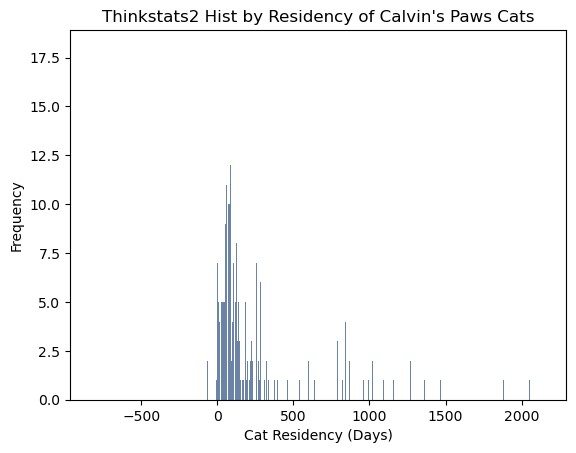

<Figure size 800x600 with 0 Axes>

In [209]:
adoptability = adoptability_report_loader()
# Thinkstats2 Histogram of the Residency data.
residency_hgram = thinkstats2.Hist(adoptability['Residency'])
thinkplot.Hist(residency_hgram)
thinkplot.Show(xlabel='Cat Residency (Days)', ylabel='Frequency', title="Thinkstats2 Hist by Residency of Calvin's Paws Cats")

(Text(0.5, 0, 'Cat Residency (Days)'),
 Text(0, 0.5, 'Frequency'),
 Text(0.5, 1.0, 'Pyplot Stairs Histogram of Residency'))

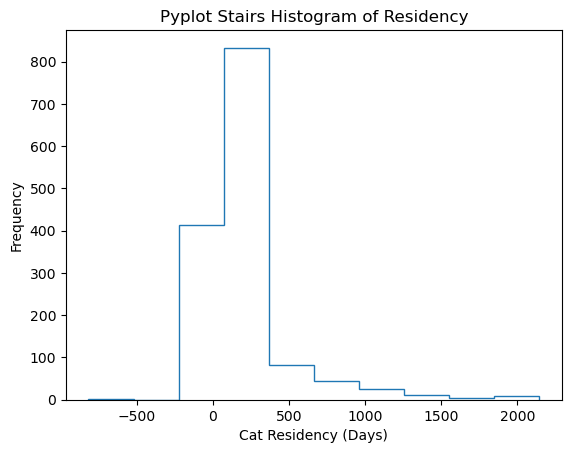

In [210]:
# Pyplot Step Function acting as a histogram analog
whole_counts, whole_bins = np.histogram(adoptability['Residency']) 
plt.stairs(whole_counts, whole_bins)
plt.xlabel("Cat Residency (Days)"), plt.ylabel("Frequency"), plt.title("Pyplot Stairs Histogram of Residency")

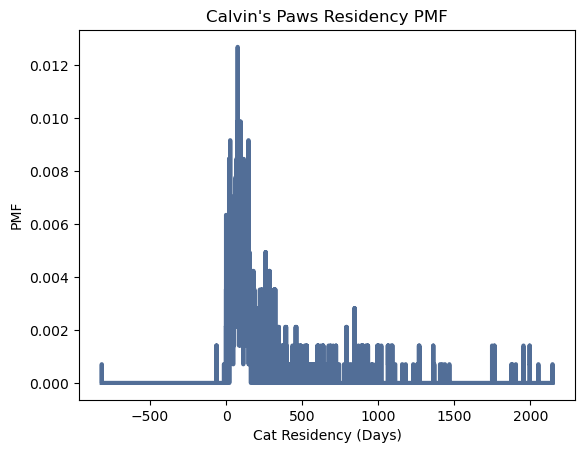

<Figure size 800x600 with 0 Axes>

In [211]:
# PMF of Residency Data
residency_pmf = thinkstats2.Pmf(adoptability['Residency'])
thinkplot.Pmf(residency_pmf)
thinkplot.Show(xlabel='Cat Residency (Days)', ylabel='PMF', title="Calvin's Paws Residency PMF")

In [212]:
adoptability.agg({'Residency': ["min", "max", "median", "mean", "std", "count"]})

,Residency
min,-817.000000
max,2145.000000
median,107.000000
mean,196.580986
std,276.506391
count,1420.000000


So this is a bit of a wild ride for initial plottings. Turns out, histograms from ThinkStats2 have bin widths of 1 and there is no text in thinkstats2.py or thinkplot.py to try and change that. The result is a histogram that looks at the exact number of occurrances of each exact number in a dataset with 1,420 entries spanning a wide range. This won't be as much of a problem later on during the text analysis, but it sure is one now.
<br>
<br>
To compensate for our thinner-than-hair histogram, I went and plotted a pyplot stair function with reasonably sized bins that looks MUCH better. The distribution looks skewed to the left, at least towards 0, and there are probably some high up outliers lurking in the 2000 day neighborhood.
<br>
<br>
The PMF created appears to corroborate this idea. A PMF maps a value in a dataset to its probability. The highest probablity found here is just above 1.2% due to the sheer number of individual values across all of the datapoints. Its general shape resembles that of the histograms from thinkplot and pyplot, which is also a good sign.
<br>
<br>
The summary statistics printed after the plots give us a stark picture. The median residency for the 2014-2023 data is 107 days with a mean of 196.58 days and a standard deviation of 276.51 days. The mean and standard deviation are likely influenced by the number of outlier datapoints, mostly on the higher end of the residency numbers. There are a couple of odd points below zero as well, cats that were adopted but added to the system some time after their adoption. A second look at these summary statistics without the presence of the outliers could be performed to see how they change.

,Residency
min,-64.000000
max,1020.000000
median,105.000000
mean,165.931358
std,186.492546
count,1384.000000


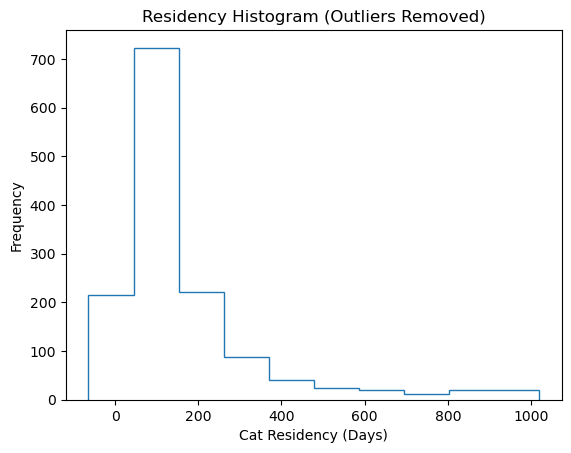

In [213]:
# Creating a z-score field to identify which lines are outliers.
adoptability['Residency z'] = ((adoptability['Residency'] - adoptability['Residency'].mean()) / adoptability['Residency'].std())
# Filtering out the outliers into their own dataframe
adoptability_filt, adopt_outliers = adoptability_outliers(adoptability)
# Creating the histogram of non-outlier data
filt_counts, filt_bins = np.histogram(adoptability_filt['Residency'])
plt.stairs(filt_counts, filt_bins)
plt.xlabel("Cat Residency (Days)"), plt.ylabel("Frequency"), plt.title("Residency Histogram (Outliers Removed)")
# Summary statistics for non-outlier data for comparison
adoptability_filt.agg({'Residency': ["min", "max", "median", "mean", "std", "count"]})

The stair-histogram for the non-outlier data still has the same shape, skewed leftward. The median did not change very much, it dropped from 107 to 105. The removal of around 40 data points only shifted the median by two, giving the impression that this statistic will be a stable statistic for the dataset. The post-outlier mean dropped from 196.58 to 165.93 days. That represents an entire month of residency with Calvin's Paws for a cat. The standard deviation had a very large drop from 276.50 to 186.49 days. That represents a difference in standard deviation of three whole months!

***Analysis by Breed***
<br>


To analyze by breed, we will first want to check how many different breeds are in the dataset as well as the number of each breed occurring.

In [214]:
adoptability_filt.groupby(['Primary Breed']).count()['Rescue ID']

Primary Breed
Abyssinian                5
Bengal                    2
Domestic Long Hair       90
Domestic Medium Hair     88
Domestic Short Hair     995
Himalayan                 1
Maine Coon              104
Manx                      1
Norwegian Forest Cat     12
Oriental Short Hair       4
Persian                   1
Ragdoll                  14
Russian Blue             19
Scottish Fold             1
Siamese                  37
Snowshoe                  5
Turkish Van               5
Name: Rescue ID, dtype: int64

We can see that there are a number of breeds, most of which are some form of domestic. We can compare the breeds residencies through comparing domestics versus non-domestics. So we can run our domestics_splitter function to make the split into two dataframes and then continue breed comparison from there.

,Residency
min,-64.000000
max,1020.000000
median,111.000000
mean,173.843990
std,191.694172
count,1173.000000


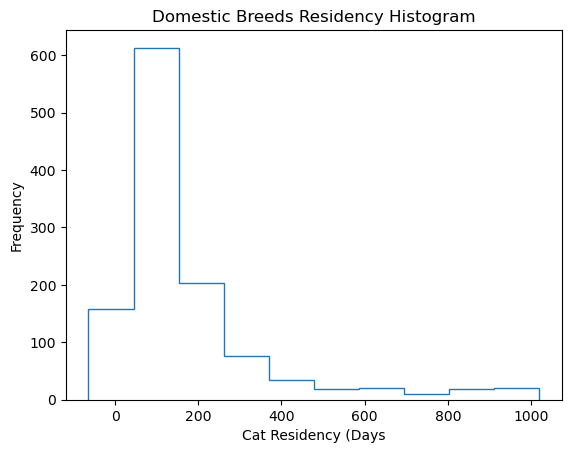

In [215]:
domestics, nondomestics = domestics_splitter(adoptability_filt)
# Showing the histogram and summary statistics for domestic breeds
domestic_counts, domestic_bins = np.histogram(domestics['Residency'])
plt.stairs(domestic_counts, domestic_bins)
plt.xlabel("Cat Residency (Days"), plt.ylabel("Frequency"), plt.title("Domestic Breeds Residency Histogram")
domestics.agg({'Residency': ["min", "max", "median", "mean", "std", "count"]})

,Residency
min,-6.000000
max,897.000000
median,78.000000
mean,121.943128
std,147.215542
count,211.000000


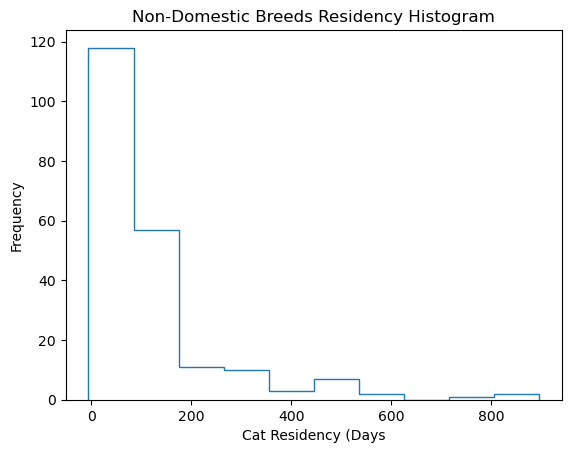

In [216]:
# Showing the histoogram and summary statistics for non-domestic breeds
nondomestic_counts, nondomestic_bins = np.histogram(nondomestics['Residency'])
plt.stairs(nondomestic_counts, nondomestic_bins)
plt.xlabel("Cat Residency (Days"), plt.ylabel("Frequency"), plt.title("Non-Domestic Breeds Residency Histogram")
nondomestics.agg({'Residency': ["min", "max", "median", "mean", "std", "count"]})

The histograms for the comparison of domestic vs non-domestic breeds show that cats labeled as non-domestic breeds tend to have shorter residencies and the summary statistics for each back that up. Domestic breed cats have a median residency of 111 days while non-domestics have a median residency of 78 days. That is a difference of an entire month! The mean and standard deviations show a similar phenomena, with the difference between the means coming to 52 days and the difference between the standard deviations being almost 50 days.
<br>
<br>
Creating CDFs and survival curves for each and presenting them will likely illustrate this as well.

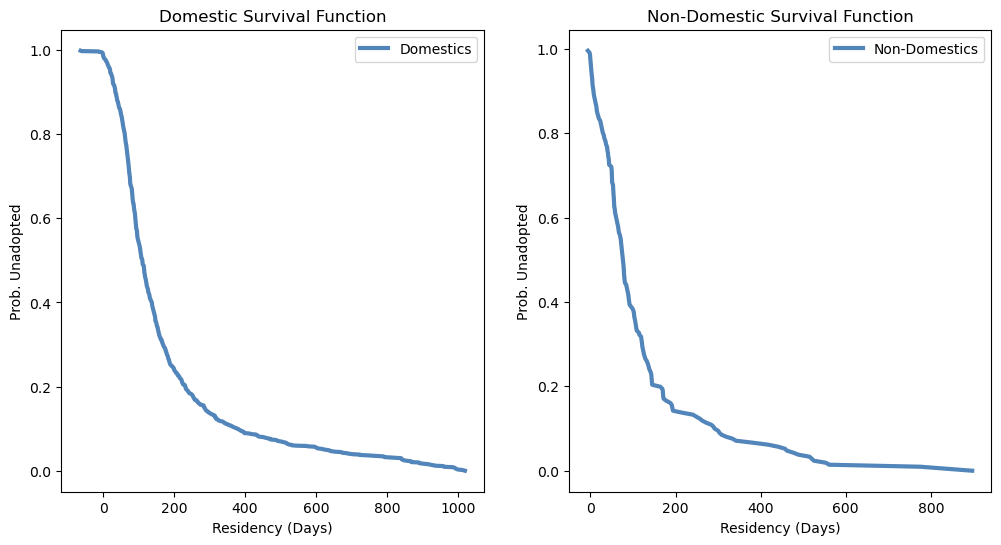

In [217]:
# Creating CDFs of domestics and non-domestic breeds
domestic_cdf = thinkstats2.Cdf(domestics['Residency'])
nondomestic_cdf = thinkstats2.Cdf(nondomestics['Residency'])
# Creating Survival Functions for domestic and non-domestic breeds
domestic_sf = survival.MakeSurvivalFromCdf(domestic_cdf, label='Domestics')
nondomestic_sf = survival.MakeSurvivalFromCdf(nondomestic_cdf, label='Non-Domestics')
# Plotting the two survival functions side by side
thinkplot.PrePlot(2, cols=2)
thinkplot.Plot(domestic_sf)
thinkplot.Config(xlabel='Residency (Days)', ylabel='Prob. Unadopted', title='Domestic Survival Function')
thinkplot.PrePlot(2)
thinkplot.SubPlot(2)
thinkplot.Plot(nondomestic_sf)
thinkplot.Config(xlabel='Residency (Days)', ylabel='Prob. Unadopted', title='Non-Domestic Survival Function')

In [218]:
# Breeds Difference in Means by Permutation Test
brdata = domestics['Residency'], nondomestics['Residency']
br_mean_ht = hypothesis.DiffMeansPermute(brdata)
br_mean_pvalue = br_mean_ht.PValue()
print("The p-value for a difference of means test by permutation is", br_mean_pvalue)

The p-value for a difference of means test by permutation is 0.0


We can see the initial downward slope for the non-domestic breeds is steeper and eventually reaches 0 faster than the domestic breed cats.
<br>
<br>
We can also use a p-value from the difference of means permutation to show that domestic vs nondomestic breeds has significance.

***Analysis by Coloration***
<br>
<br>
The domestic breed cats have various colorations. It would be fair to assume that the color of a cat likely has an effect on when it gets adopted, but we should look into it further.

In [219]:
domestics.groupby('Color (General)').agg({'Residency': ["count", "median", "mean", "std"]})

Residency                               
                               count median        mean         std
Color (General)                                                    
Black                            150  116.0  203.420000  227.508279
Black (Mostly)                    44  117.5  207.568182  204.305790
Black and White                  173  116.0  177.913295  188.883342
Brown                              1  138.0  138.000000         NaN
Brown (Mostly)                     5  141.0  162.400000   95.850404
Brown Tabby                      189  115.0  175.783069  191.637736
Calico or Dilute Calico          106  106.5  143.764151  148.004218
Chocolate                          2   86.5   86.500000   85.559921
Cream (Mostly)                     2   63.0   63.000000   11.313708
Gray                              50   75.0  138.340000  177.284461
Gray  Blue or Silver Tabby        21  102.0  103.952381   35.224248
Gray (Mostly)                     64  125.0  187.140625  199.632350
Gray and White                    78  117.5  187.141026  216.136604
Orange                           105   91.0  142.085714  171.850456
Orange (Mostly)                   37  132.0  147.702703  125.819064
Orange and White                  43  102.0  175.534884  184.459745
Red Tabby                          1   89.0   89.000000         NaN
Tan                                2  155.5  155.500000  144.956890
Tan (Mostly)                       1  219.0  219.000000         NaN
Tortoiseshell                     67  140.0  225.343284  247.678956
Tuxedo                             5  147.0  134.800000   40.220641
White                             14   82.0   79.714286   43.418232
White (Mostly)                    13  111.0  205.384615  171.872791

In the domestics dataset, we have 23 different colorations and by using groupby and agg in conjunction with each other, we can see what effects a cat's coloration can have on its adoption prospects. The count column will let us see how many of each coloration are present in the domestics dataset and work with those that are suitable for analysis. We will look into coloraitons that have at least 10 cats of the particular color.
<br>
<br>
It is worth noting that the median, mean, and stadard deviation all of the domestics population is 111, 173.84, and 191.69 days, respectively. Given that and out choice to look at colorations with at least 10 entries, we can see that pure grey, pure orange, and pure white cats all had shorter residencies when compared to the other colorations. Tortoiseshells (torties), had notably higher residencies across all metrics. Black cats had median residencies close to the group median but their mean and standard deviations of residency were higher than those of the whole group. 
<br>
<br>
We can select the colorations noted and check if the difference in their means is significant. 

In [220]:
# Tortie Dataset
torties = adoptability_filt[adoptability_filt['Color (General)'].map(lambda x: x == "Tortoiseshell")]
not_torties = adoptability_filt[adoptability_filt['Color (General)'].map(lambda x: x != "Tortoiseshell")]
# Tortie Test
tdata = torties['Residency'], not_torties['Residency']
tht = hypothesis.DiffMeansPermute(tdata)
tpvalue = tht.PValue()
print("The p-value for a difference of means test among tortie vs non-tortie cats residencies is", tpvalue)
# Oranges Dataset
oranges = adoptability_filt[adoptability_filt['Color (General)'].map(lambda x: x == "Orange")]
not_oranges = adoptability_filt[adoptability_filt['Color (General)'].map(lambda x: x != "Orange")]
# Oranges Test
odata = oranges['Residency'], not_oranges['Residency']
oht = hypothesis.DiffMeansPermute(odata)
opvalue = oht.PValue()
print("The p-value for a difference of means test among orange vs non-orange cats residencies is", opvalue)
# White Dataset
whites = adoptability_filt[adoptability_filt['Color (General)'].map(lambda x: x == "White")]
not_whites = adoptability_filt[adoptability_filt['Color (General)'].map(lambda x: x != "White")]
# White Test
wdata = whites['Residency'], not_whites['Residency']
wht = hypothesis.DiffMeansPermute(wdata)
wpvalue = wht.PValue()
print("The p-value for a difference of means test among white vs non-white cats residencies is", wpvalue)
# Black Dataset
blacks = adoptability_filt[adoptability_filt['Color (General)'].map(lambda x: x == "Black")]
not_blacks = adoptability_filt[adoptability_filt['Color (General)'].map(lambda x: x != "Black")]
# Black Test
bdata = blacks['Residency'], not_blacks['Residency']
bht = hypothesis.DiffMeansPermute(bdata)
bpvalue = bht.PValue()
print("The p-value for a difference of means test among black vs non-black cats residencies is", bpvalue)

The p-value for a difference of means test among tortie vs non-tortie cats residencies is 0.005
The p-value for a difference of means test among orange vs non-orange cats residencies is 0.097
The p-value for a difference of means test among white vs non-white cats residencies is 0.018
The p-value for a difference of means test among black vs non-black cats residencies is 0.003


The difference in means testing shows that the difference in means for torties, white cats, and black cats are significant. There could be bias for white cats and against for torties and black cats. The test for oranges showed a non-significant p-value

***Analysis by Sex of the Cat***
<br>
<br>
The sex of the cat is another trait that may affect a cat's adoptability. When someone goes to adopt a cat, they may have a preference as to what the sex of the cat they're looking to adopt is. For that reason, we will check this by splitting the adoptability_filt dataframe into males and females and check their summary statistics and plots.

In [221]:
males, females = sex_splitter(adoptability_filt)

,Residency
min,-64.000000
max,1020.000000
median,100.000000
mean,162.279699
std,183.166492
count,665.000000


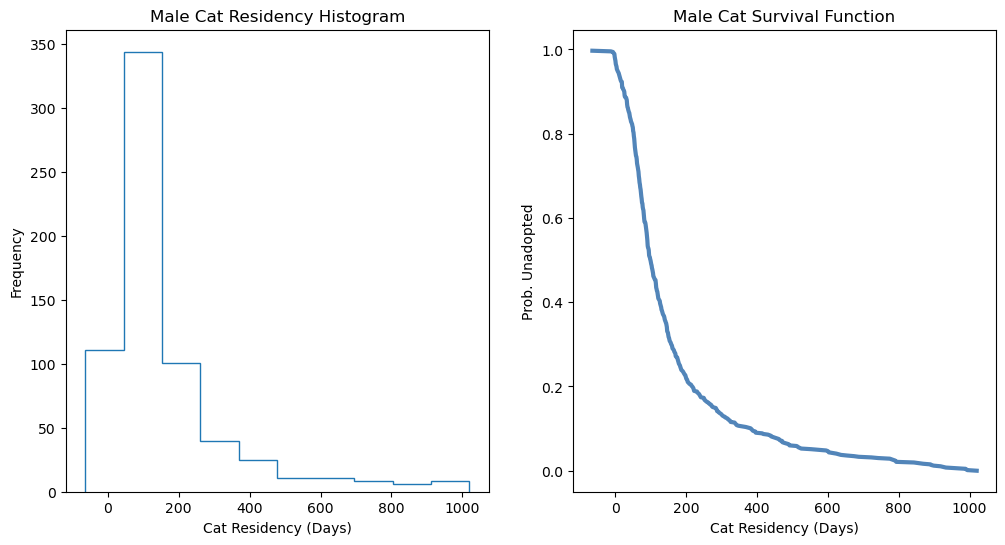

In [222]:
# Male Plotting and Statistics
male_counts, male_bins = np.histogram(males['Residency'])
male_cdf = thinkstats2.Cdf(males['Residency'])
males_sf = survival.MakeSurvivalFromCdf(male_cdf)

thinkplot.PrePlot(2, cols=2)
plt.stairs(male_counts, male_bins)
thinkplot.Config(xlabel='Cat Residency (Days)', ylabel='Frequency', title='Male Cat Residency Histogram')
thinkplot.PrePlot(2)
thinkplot.SubPlot(2)
thinkplot.Plot(males_sf)
thinkplot.Config(xlabel='Cat Residency (Days)', ylabel='Prob. Unadopted', title='Male Cat Survival Function')
males.agg({'Residency': ["min", "max", "median", "mean", "std", "count"]})

,Residency
min,-62.000000
max,1020.000000
median,107.000000
mean,169.308762
std,189.581571
count,719.000000


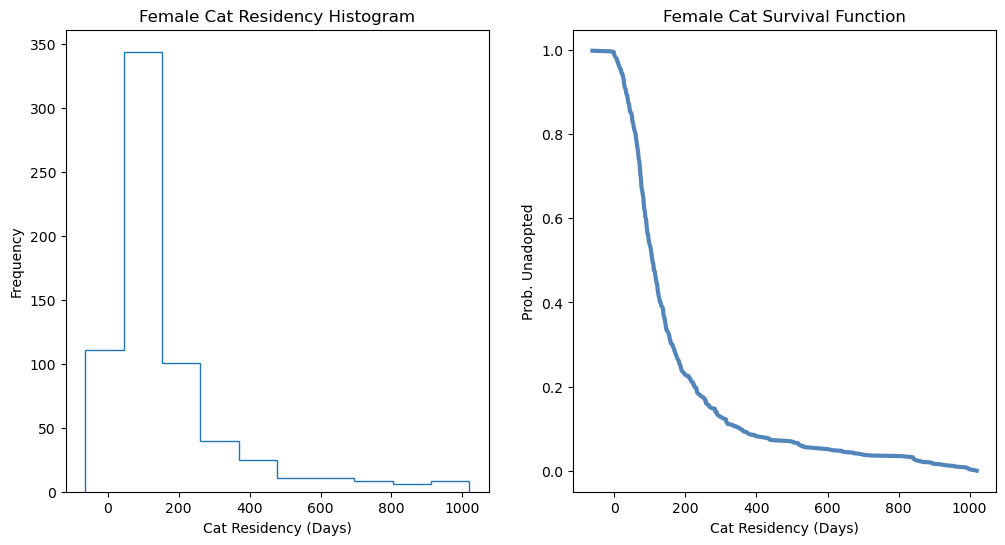

In [223]:
# Female Plotting and Statistics
female_counts, female_bins = np.histogram(males['Residency'])
female_cdf = thinkstats2.Cdf(females['Residency'])
females_sf = survival.MakeSurvivalFromCdf(female_cdf)

thinkplot.PrePlot(2, cols=2)
plt.stairs(female_counts, female_bins)
thinkplot.Config(xlabel='Cat Residency (Days)', ylabel='Frequency', title='Female Cat Residency Histogram')
thinkplot.PrePlot(2)
thinkplot.SubPlot(2)
thinkplot.Plot(females_sf)
thinkplot.Config(xlabel='Cat Residency (Days)', ylabel='Prob. Unadopted', title='Female Cat Survival Function')
females.agg({'Residency': ["min", "max", "median", "mean", "std", "count"]})

In [224]:
# Permutation of Means Test
sdata = males['Residency'], females['Residency']
sht = hypothesis.DiffMeansPermute(sdata)
spvalue = sht.PValue()
print("The p-value for a difference of means test among male vs female residencies is", spvalue)

The p-value for a difference of means test among male vs female residencies is 0.476


By comapring the histograms and survival functions plotted for the male and female cats, we can see that they are incredibly similar to each other. The summary statistics taken for each are also quite similar. The male median is 100 days while the female median is 107 days. The means are 162.28 days and 169.31 days, respectively. The male standard deviation is 183.17 days while the female standard deviation is 189.58 days. To top that off, the p-value for a difference of means test shows that the difference in mean residencies is not significant.

***Analysis by Cat's Age at Entry***
<br>
<br>
While running the adoptability report loader, a field for Entry Age was created in order to analyze if the age at which a cat entered Calvin's Paws affected its adoptability. We do know that people love kittens, so we can make a scatter plot of Entry Age vs Residency to see how the data is distributed. I am anticipating that a number of points could end up covering each other, so a second plot with some fading can help with that and show where the points end up having the most density

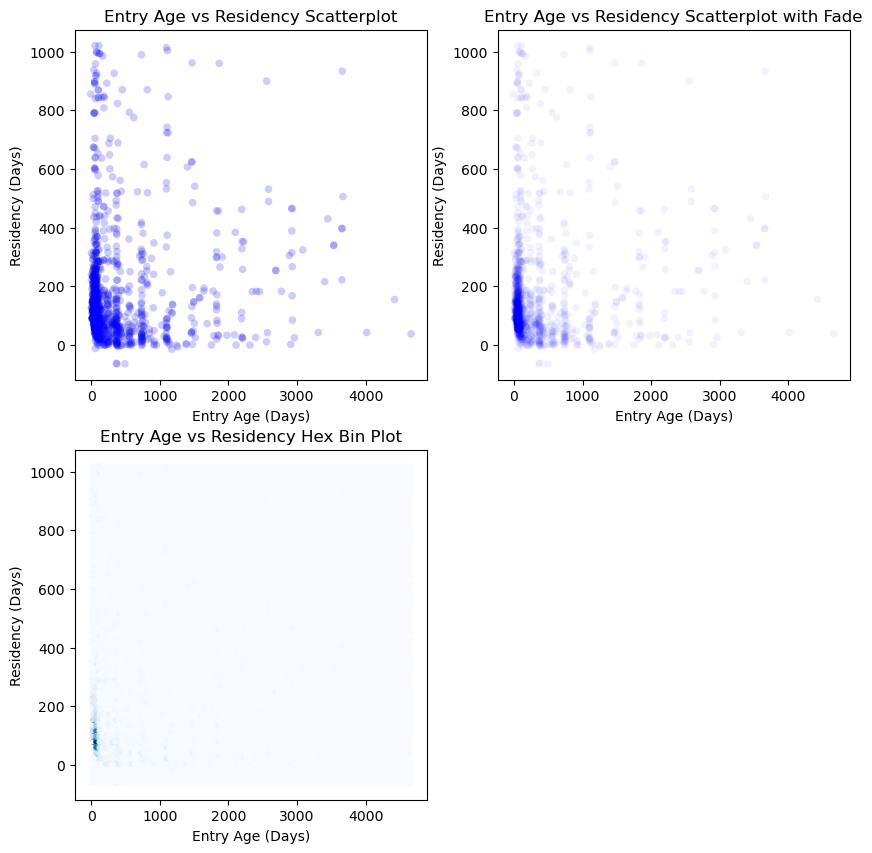

In [225]:
thinkplot.PrePlot(3, rows=2, cols=2)
thinkplot.Scatter(adoptability_filt['Entry Age'], adoptability_filt['Residency'])
thinkplot.Config(xlabel="Entry Age (Days)",
              ylabel="Residency (Days)",
              title="Entry Age vs Residency Scatterplot")
thinkplot.PrePlot(2)
thinkplot.SubPlot(2)
thinkplot.Scatter(adoptability_filt['Entry Age'], adoptability_filt['Residency'], alpha=0.05)
thinkplot.Config(xlabel="Entry Age (Days)",
              ylabel="Residency (Days)",
              title="Entry Age vs Residency Scatterplot with Fade")
thinkplot.PrePlot(3)
thinkplot.SubPlot(3)
thinkplot.HexBin(adoptability_filt['Entry Age'], adoptability_filt['Residency'])
thinkplot.Config(xlabel="Entry Age (Days)",
              ylabel="Residency (Days)",
              title="Entry Age vs Residency Hex Bin Plot")

We can clearly see from the plots that age could very well be a factor in the residency of a cat. So to check this, we should look and see if there is a correlation between the variables and check the summary statistics for kittens vs non-kittens.

In [226]:
# General Correlation Between Entry Age and Residency
age_res_corr = thinkstats2.Corr(adoptability_filt['Entry Age'], adoptability_filt['Residency'])
print("The Pearson correlation value for Entry Age and Residency is", age_res_corr)
adopt_corr_data = adoptability_filt['Entry Age'], adoptability_filt['Residency']
adopt_corr_ht = hypothesis.CorrelationPermute(adopt_corr_data)
adopt_corr_pvalue = adopt_corr_ht.PValue()
print("The p-value for the correlation between Entry Age and Residency is", adopt_corr_pvalue)

The Pearson correlation value for Entry Age and Residency is 0.11081474052226403
The p-value for the correlation between Entry Age and Residency is 0.0


While the Pearson correlation value for Entry Age and Residency is barely positive, the correlation test from ThinkStats says that it should be considered significant. This is likely due to the difference in desirability of kittens vs non-kittens. So we can split our data along those lines and check the summary statistics. We will use the arbitrary time of 365 days (one year) of entry age to determine if the cat is a kitten or not.

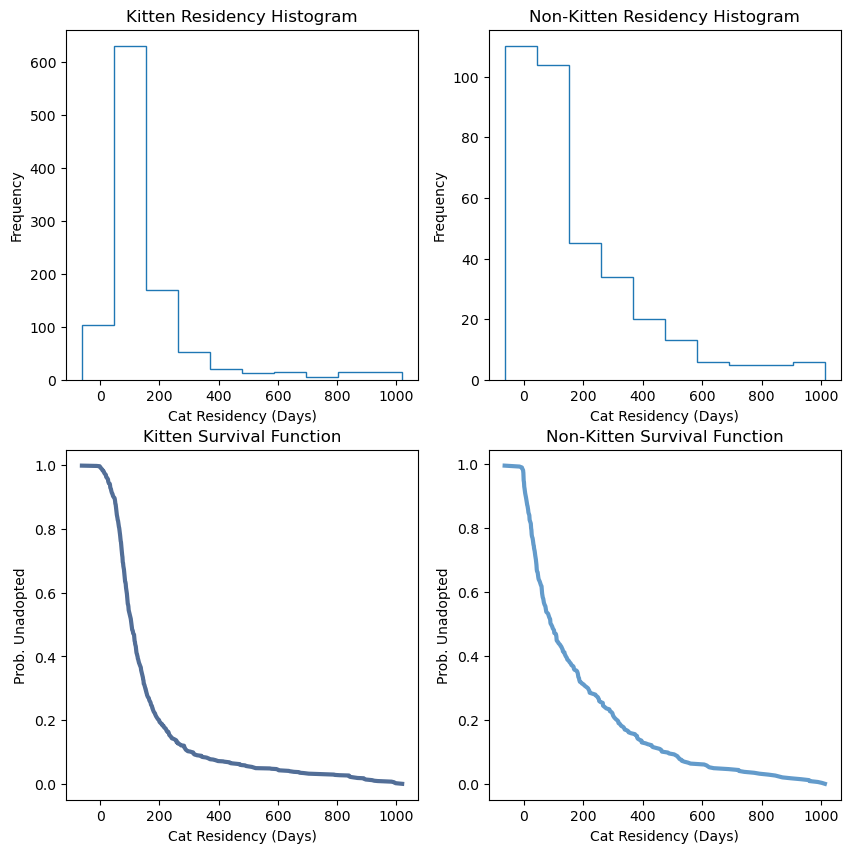

In [227]:
# Creating the Kitten and Non-Kitten datasets
kittens = adoptability_filt[adoptability_filt['Entry Age'].map(lambda x: x <= 365)]
not_kittens = adoptability_filt[adoptability_filt['Entry Age'].map(lambda x: x > 365)]
# Creating Survival Functions for the Kittens and Non-Kittens
kitten_cdf = thinkstats2.Cdf(kittens['Residency'])
not_kitten_cdf = thinkstats2.Cdf(not_kittens['Residency'])
kitten_sf = survival.MakeSurvivalFromCdf(kitten_cdf)
not_kitten_sf = survival.MakeSurvivalFromCdf(not_kitten_cdf)
# Creating the Histograms
kitten_counts, kitten_bins = np.histogram(kittens['Residency'])
not_kitten_counts, not_kitten_bins = np.histogram(not_kittens['Residency'])
# Plotting the graphs
thinkplot.PrePlot(4, rows=2, cols=2)
thinkplot.SubPlot(1)
plt.stairs(kitten_counts, kitten_bins)
thinkplot.Config(xlabel='Cat Residency (Days)', ylabel='Frequency', title='Kitten Residency Histogram')
thinkplot.SubPlot(2)
plt.stairs(not_kitten_counts, not_kitten_bins)
thinkplot.Config(xlabel='Cat Residency (Days)', ylabel='Frequency', title='Non-Kitten Residency Histogram')
thinkplot.SubPlot(3)
thinkplot.Plot(kitten_sf)
thinkplot.Config(xlabel='Cat Residency (Days)', ylabel='Prob. Unadopted', title='Kitten Survival Function')
thinkplot.SubPlot(4)
thinkplot.Plot(not_kitten_sf)
thinkplot.Config(xlabel='Cat Residency (Days)', ylabel='Prob. Unadopted', title='Non-Kitten Survival Function')

The histograms and survival functions have different patterns to them. While they have different heights, we can see from their shapes at their scales that the kittens get adopted earlier, in general, than non-kittens. We can show this using summary statistics and a difference of means test using permutation.

In [228]:
# Kittens Summary Statistics
kittens.agg({'Residency': ["min", "max", "median", "mean", "std", "count"]})

,Residency
min,-62.000000
max,1020.000000
median,106.000000
mean,160.683398
std,175.008141
count,1036.000000


In [229]:
# Non-Kitten Summary Statistics
not_kittens.agg({'Residency': ["min", "max", "median", "mean", "std", "count"]})

,Residency
min,-64.000000
max,1013.000000
median,92.000000
mean,181.554598
std,216.646620
count,348.000000


In [230]:
kdata = kittens['Residency'], not_kittens['Residency']
kht = hypothesis.DiffMeansPermute(kdata)
kpvalue = kht.PValue()
print('The p-value for the difference of means between kittens and non-kittens is', kpvalue)

The p-value for the difference of means between kittens and non-kittens is 0.08


These summary statistics and p-value paint a puzzling picture. While the barely positive correlation has statistical significance, the difference in mean adoption times between kittens and non-kittens is just outside of statistical significance if that threshold is taken to be a p-value of 0.05. The p-value for the difference of means floats between the neighborhoods of .06 and .08. This is still a low p-value, but its statistical significance is uncertain at best. This could be due to the mismatch in the sizes of the datasets: 1036 kittens (cats that entered Calvin's Paws at less than or equal to 365 days old) and 348 non-kittens (cats that entered Calvin's Paws at older than 365 days).
<br>
<br>
After finding this, I decided to draw up a parallel hypothesis test using the median instead of the mean and called it DiffMediansPermute. It was written to basically mirror the DiffMeansPermute class from thinkstats2 and replace mean with median, but it ran into a fatal flaw: numpy.ndarray does not have a median method. This is used in calculating the p-value. So I was unfortunate in that endeavor.

***Analysis by Cat's Name***
<br>
<br>
A major part of choosing a cat to adopt from a rescue like Calvin's Paws is going through the cats they have available. Since their cats are shown in alphabetical order, the first letter of a cat's name could have an impact on how quickly they get adopted based on the idea that cats seen earlier (with letters earlier in the alphabet) could get applied for and adopted sooner than others. We can create a field based on the name of each cat that gives us that and we can then analyze statistics and test letters that stand out to us.

In [247]:
adoptability_filt['First Letter'] = first_letter(adoptability_filt['Name'])
adoptability_filt.groupby('First Letter').agg({'Residency': ["count", "median", "mean", "std"]})

Residency                               
                 count median        mean         std
First Letter                                         
A                   87   95.0  140.689655  160.932552
B                  114  110.5  151.175439  148.057406
C                  145  111.0  179.144828  198.952150
D                   71  116.0  146.183099  141.734491
E                   36  110.0  166.444444  180.716739
F                   38  104.5  191.289474  225.866489
G                   44   79.5  149.840909  188.849016
H                   41   96.0  145.365854  166.849147
I                   12  105.0  134.333333   96.582827
J                   53   93.0  177.471698  213.826008
K                   37  131.0  212.567568  249.896705
L                   93  101.0  128.623656  113.690074
M                  142  100.0  182.436620  215.501706
N                   35   96.0  247.542857  301.599008
O                   23  116.0  163.086957  146.590621
P                   86   80.0  163.651163  225.569802
Q                    4  149.5  133.250000   47.062901
R                   58  121.0  175.603448  173.172254
S                  128  126.0  188.843750  189.446497
T                   88  112.0  158.840909  163.365811
U                    1   87.0   87.000000         NaN
V                   15   58.0   55.533333   33.107761
W                   23   95.0  171.130435  166.953261
Y                    2   91.0   91.000000   35.355339
Z                    8  103.5  107.500000   68.435580

Keeping in mind that the median, mean, and standard deviation of residency for the general population are 105, 165.93, and 186.49 days, respectively, we can compare the summary statistics for the letters with sufficient representation (at least 25 entries). Afterwards, we can test a couple for statistically significant differences in means.
<br>
Immediately we see that A has a lower mean, as does H. At the same time, K and N have higher means. We can test these four letters to see if their differences in mean versus the rest of the populaiton are statistically significant.

In [253]:
# A Dataset
a_cats = adoptability_filt[adoptability_filt['First Letter'].map(lambda x: x == "A")]
not_a_cats = adoptability_filt[adoptability_filt['First Letter'].map(lambda x: x != "A")]
# A Test
adata = a_cats['Residency'], not_a_cats['Residency']
aht = hypothesis.DiffMeansPermute(adata)
apvalue = aht.PValue()
print("The p-value for a difference of means test among A's vs non-A cats residencies is", apvalue)
# H Dataset
h_cats = adoptability_filt[adoptability_filt['First Letter'].map(lambda x: x == "H")]
not_h_cats = adoptability_filt[adoptability_filt['First Letter'].map(lambda x: x != "H")]
# H Test
hdata = h_cats['Residency'], not_h_cats['Residency']
hht = hypothesis.DiffMeansPermute(hdata)
hpvalue = hht.PValue()
print("The p-value for a difference of means test among H's vs non-H cats residencies is", hpvalue)
# K Dataset
k_cats = adoptability_filt[adoptability_filt['First Letter'].map(lambda x: x == "K")]
not_k_cats = adoptability_filt[adoptability_filt['First Letter'].map(lambda x: x != "K")]
# K Test
kdata = k_cats['Residency'], not_k_cats['Residency']
kht = hypothesis.DiffMeansPermute(hdata)
kpvalue = kht.PValue()
print("The p-value for a difference of means test among K's vs non-K cats residencies is", kpvalue)
# N Dataset
n_cats = adoptability_filt[adoptability_filt['First Letter'].map(lambda x: x == "N")]
not_n_cats = adoptability_filt[adoptability_filt['First Letter'].map(lambda x: x != "N")]
# N Test
ndata = n_cats['Residency'], not_n_cats['Residency']
nht = hypothesis.DiffMeansPermute(ndata)
npvalue = nht.PValue()
print("The p-value for a difference of means test among N's vs non-N cats residencies is", npvalue)

The p-value for a difference of means test among A's vs non-A cats residencies is 0.185
The p-value for a difference of means test among H's vs non-H cats residencies is 0.481
The p-value for a difference of means test among K's vs non-K cats residencies is 0.475
The p-value for a difference of means test among N's vs non-N cats residencies is 0.005


The result for our tests here are mixed. The differences in means for a letter versus not that letter were not statistically significant for A, H, and K. Our initial thought was to see if letters earlier in the alphabet fared better (having shorter residencies) and A and H did not pan out in this respect. K did not either, even with its mean being above that of the whole population. On the other hand, N's difference in mean was considered statistically significant. Given these tests, it is unlikely that the first letter of a cat's name has an impact on its residency. Further testing could be conducted to look into it though.

***Adoptability Analysis Summary***

We found in the analysis of the Adoptability Report that breed and some aspects of coloration are statistically significant to the amount of time a cat spent with Calvin's Paws. The sex of the cat was far from significant. There is a fairly small positive correlation between the age at which a cat enters the rescue that is statistically significant but no statistical significance to the difference between the mean residencies of kittens and non-kittens. Lastly, the name a cat has is unlikely to have impact on its adoption prospects.

**Analysis of the Cost Report**
<br>
<br>
The Cost report is a subreport of the Adoptability Report with a major difference: it has columns for Date and Adopted Date. These two columns correspond to the dates adoptions took place. A cat can appear more than once in this report if it was returned and re-adopted. This causes a couple of complications for summary statistics and residency (Length of Stay in the Cost Report). First, the cost spent on medical care is the total spent on a cat. If a cat appears more than once in the report, its cost appears more than once too. Second, if a cat is listed multiple times, the Adopted Date is the date of adoption for the individual instance of the cat being with Calvin's Paws. The value in the Date column is the date of the latest adoption. This means that one cat could have multiple residencies/lengths of stay. The value in that column is cumulative according to the report, so the value that matches the Residency value in the Adoptablity Report is the largest value. To make sure our Cost Report data agrees with the data from the Adoptability Report, we will need to index the dataframe for all entries where the Adopted Date equals the Date.

In [231]:
# Loading the Cost Report
cost = cost_report_loader()
# Filtering the cost dataframe by indexing where Adoption Date matches Date
cost_dfilt = cost[cost['Adopted Date'] == cost['Date']]
# Summary Statistics for filtered cost dataframe
cost_dfilt.agg({'Cost': ["min", "max", "median", "mean", "std", "count"],
              'Length of Stay': ["min", "max", "median", "mean", "std", "count"]})

,Cost,Length of Stay
min,0.000000,-817.000000
max,4627.900000,2145.000000
median,115.750000,111.000000
mean,145.415683,201.371997
std,196.391571,279.124562
count,1457.000000,1457.000000


The Pearson correlation value for Cost vs Length of Stay is 0.18790670279477203
The p-value for the correlation between Cost and Length of Stay is 0.0


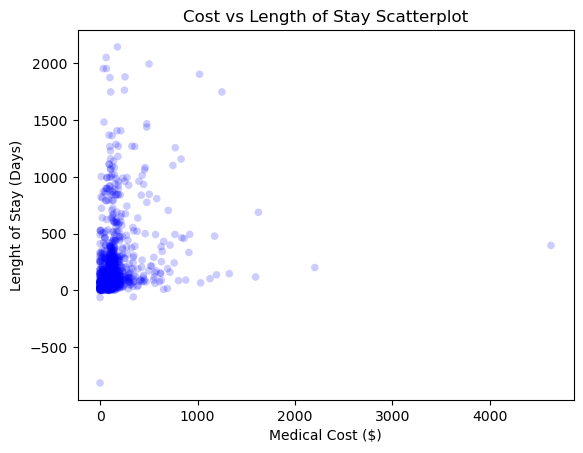

In [232]:
# Plotting filtered cost dataframe scatterplot
thinkplot.Scatter(cost_dfilt['Cost'], cost_dfilt['Length of Stay'])
thinkplot.Config(xlabel='Medical Cost ($)', ylabel='Lenght of Stay (Days)', title='Cost vs Length of Stay Scatterplot')
# Correlation for Cost vs Length data
whole_cost_corr = thinkstats2.Corr(cost_dfilt['Cost'], cost_dfilt['Length of Stay'])
print('The Pearson correlation value for Cost vs Length of Stay is', whole_cost_corr)
whole_cost_corr_data = cost_dfilt['Cost'], cost_dfilt['Length of Stay']
whole_cost_corr_ht = hypothesis.CorrelationPermute(whole_cost_corr_data)
whole_cost_corr_pvalue = whole_cost_corr_ht.PValue()
print('The p-value for the correlation between Cost and Length of Stay is', whole_cost_corr_pvalue)

The summary statistics for the Cost Report show a wide range of data for Cost and Length of Stay. We can see single points flung far off at the edges of each axis as well, with those points likely being outliers. To get a better view of the plot and summary statistics, we can filter out those points.
<br>
At the same time, the Pearson correlation constant for the data is around 0.19 and is statistically significant.

C:\Users\dman1\AppData\Local\Temp\ipykernel_6292\609886999.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cost_dfilt['Cost z'] = ((cost_dfilt['Cost'] - cost_dfilt['Cost'].mean()) / cost_dfilt['Cost'].std())
C:\Users\dman1\AppData\Local\Temp\ipykernel_6292\609886999.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cost_dfilt['Length z'] = ((cost_dfilt['Length of Stay'] - cost_dfilt['Length of Stay'].mean()) / cost_dfilt['Length of Stay'].std())


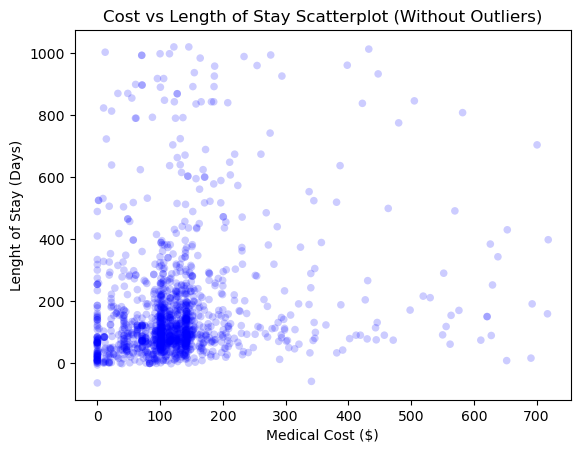

In [233]:
# Creating z-scores for Cost and Length
cost_dfilt['Cost z'] = ((cost_dfilt['Cost'] - cost_dfilt['Cost'].mean()) / cost_dfilt['Cost'].std())
cost_dfilt['Length z'] = ((cost_dfilt['Length of Stay'] - cost_dfilt['Length of Stay'].mean()) / cost_dfilt['Length of Stay'].std())
# Filtering out z-scores whose absolute value are greater than or equal to 3
cost_dclfilt, cost_dcloutliers = cost_outliers(cost_dfilt)
thinkplot.Scatter(cost_dclfilt['Cost'], cost_dclfilt['Length of Stay'])
thinkplot.Config(xlabel='Medical Cost ($)', ylabel='Lenght of Stay (Days)', title='Cost vs Length of Stay Scatterplot (Without Outliers)')

We have a better view of the scatterplot without the outliers causing the window to be much larger than needed. Next we can find the correlation value and test it. We can also run another round of summary statistics.

In [234]:
cost_length_corr = thinkstats2.Corr(cost_dclfilt['Cost'], cost_dclfilt['Length of Stay'])
print('The Pearson correlation value for Cost vs Length of Stay is', cost_length_corr)
cost_corr_data = cost_dclfilt['Cost'], cost_dclfilt['Length of Stay']
cost_corr_ht = hypothesis.CorrelationPermute(cost_corr_data)
cost_corr_pvalue = cost_corr_ht.PValue()
print('The p-value for the correlation between Cost and Length of Stay is', cost_corr_pvalue)
cost_dclfilt.agg({'Cost': ["min", "max", "median", "mean", "std", "count"],
              'Length of Stay': ["min", "max", "median", "mean", "std", "count"]})

The Pearson correlation value for Cost vs Length of Stay is 0.18791233264973398
The p-value for the correlation between Cost and Length of Stay is 0.0


,Cost,Length of Stay
min,0.000000,-64.000000
max,718.510000,1020.000000
median,115.230000,107.000000
mean,127.175746,167.758744
std,99.586100,186.629749
count,1401.000000,1401.000000


We can see from the Correlation Permutation test that the Pearson correlation of around 0.19 is statistically significant. At the same time, the mean medical cost per cat came to around $127.18 with a mean length of stay of around 168 days. We do see a dense cloud of points in the scatterplot around those values, so these values are likely valid. 

***Cost Report Analysis Summary***
<br>
<br>
The Cost Report gives us an opportunity to see if the amount of money spent on a cat for medical expenses has an impact on its residency/length of stay. With or without the outliers, the Pearson correlation value is just under 0.19 with it being statistically significant. The removal of the outliers created a very small difference in the value of the correlation constant and likely was unnecessary. It would be fair to say that based on this analysis, cost has some kind of small relationship with the residency/length of stay of a cat within the rescue.

**Analysis of the Denied Applications**

Total of 399 denied applications for analysis
274 different cats had denied applications


,Word,Count
0,vet,107
1,declaw,86
2,info,81
3,home,54
4,requested,48
...,...,...
248,b,5
249,asking,5
250,apply,5
251,allow,5


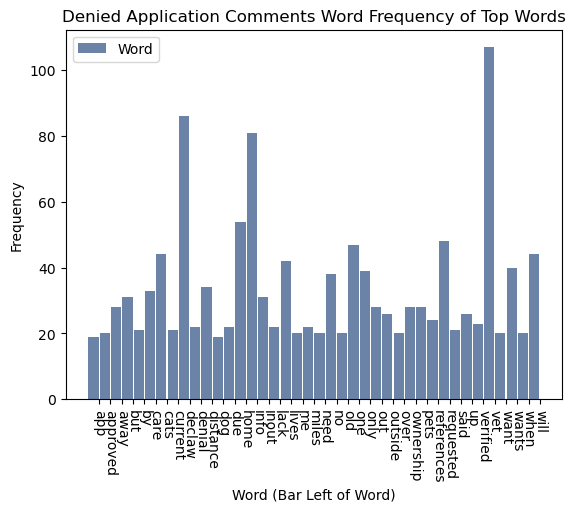

<Figure size 800x600 with 0 Axes>

In [235]:
denied_apps = pd.read_csv("Denied Applications with Comments.csv")
denied_apps.rename(columns = {'Comments (inline)':'Comments'}, inplace=True)
denied_apps = denied_apps.drop(columns=['Form ID', 'Last Name', 'Email', 'Contact ID', 'Last Name.1'])
denied_apps = denied_apps.dropna(ignore_index=True)
tags = ["F14", "F15", "F16", "F17", "F18", "F19", "F20", "F21", "F22", "F23"]
denied_apps_14on = rescueid_cleaner(denied_apps, tags)
print("Total of", len(denied_apps_14on['Rescue ID']), "denied applications for analysis")
print(len(denied_apps_14on['Rescue ID'].unique()), "different cats had denied applications")
'''
Creating the list of strings to be ignored. Contains words common in the comments that are not informational as well as the names of those writing
the comments.
'''
ignored = ["a", "an", "the", "carol", "hazlewood", "julia", "eckard", "cheryl", "kuntze", "assigned", "form", "under", "review", "wrote",
           "submitted", "under", "denied", "on", "changed", "status", "from", 'to', 'email', 'they', 'he', 'she', "and", "for", 'in', 'of', 'is',
           'i', 'that', 'her', 'him', 'michelle', 'linda', 'was', 'penny', 'their', 'our', 'applicant', 'with', 'brittany', 'this', 'application',
           'them', 'or', 'you', 'kim', 'stallings', 'showalter', 'stanley', 'susan', 'wilkie', 'roth', 'leake', 'not', 'cat', 'his', 'hers', 'are',
           'any', 'if', 'as', 'sent', 'more', 'have', 'has', 'be', 'at', 'your', 'we', 'e', 'had', 'leigh', 'had', 'did', 'n', 'about', 'also',
           'emailed', 'd', 'it', 'kitten', 'o', 'adopt', 'adoption', 'adopted', 'would']
base_dictionary = {}
for comment in denied_apps_14on.Comments:
    process_comment(comment, base_dictionary, ignored)
# Using a list to pre-sort the values catalogued from the comments and filter for words appearing with a minimum frequency.
sorting_list = []
for word in base_dictionary:
    if base_dictionary[word] >= 5:
        sorting_list.append((base_dictionary[word], word))
sorting_list.sort(reverse=True)
# Taking the sorted list and converting it into a dataframe
words = []  # Initializing the words column as a list before concatenation
count = []  # Initializing the count column as a list before concatenation
# For loop to go through the sorted list to append the words to the word list, append the counts to the count list, and filter out numbers by using
# a try block
for pair in sorting_list:
    try:
        int(pair[1]) 
        continue
    except:
        words.append(pair[1])
        count.append(pair[0])
# Creating the counts dataframe using the completed lists
counts_df = pd.DataFrame({"Word": words, "Count": count})
display(counts_df)

plotting_dictionary = {}
for i in range(40):
    plotting_dictionary[(sorting_list[i][1])] = sorting_list[i][0]
words_hgram = thinkstats2.Hist(plotting_dictionary, label='Word')
plt.xticks(rotation=-90)
thinkplot.Hist(words_hgram)
thinkplot.Show(xlabel='Word (Bar Left of Word)', ylabel='Frequency', title='Denied Application Comments Word Frequency of Top Words')

***Denied Applications Analysis Summary***
<br>
<br>
The highlights of the words found in the Denied Applications Report show that the words appearing most often include vet, declaw, info, and home. Declawing is an instant disqualifier for adoption through Calvin's Paws for the initial and future applications. Lives, home, and other words appearing in the comments indicate that living outside of the Calvin's Paws service area would be reason to deny an application. Being under 21 is also a reason, but is not as represented since numbers and the word "under" were filtered out. Vet and info's inclusion deal with needed to gather more information from applicants, usually for landlord or vet information.

**Summary of Exploratory Data Analysis Findings**
<br>
<br>
This analsyis of cat rescue data from Calvin's Paws was intended to identify possible factors that affect the adoptability of a cat in terms of "Residency," how long the cat was with the rescue/ how long its journey was to living in a forever home. I would like to think that this analysis was successful in identifying trends that affect adoptablity.
<br>
<br>
***Outcomes***
<br>
<br>
The analysis did find that facotrs like breed and coloration can positively or negatively affect a cat's adoption prospects. Cats listed as non-domestic breeds were adopted faster, those listed with specific colorations could be helped (like orange or white cats) or hindered (like torties or black cats). Rescues could use this information to help their clients, the cats, to help them get adopted into good, loving homes faster through better advertising of breeds or colorations that appear to be negatively affected. The age of a cat did have a statistically significant correlation with residency but the difference in means was just outside the significance threshold of 0.05. Maybe some leeway would need to be given since there were almost two and a half times more kittens and non-kittens. Names of cats also did not have a likely impact on the adoptability of a cat.
<br>
<br>
***Missed Items***
<br>
<br>
I felt that this analysis had most of what would be needed to conduct exploratory data analysis of the data acquired from Calvin's Paws. A lack of clearly defined returned dates and non-first adoption dates caused a detrimental over-simplification of the concept of residency for cats that ended up returned at one point. 
<br>
For cats that ended up as outliers in terms of residency for the Adoptability and Cost Reports and medical cost for the Cost Report didn't have any extra information to show why they were with the rescue for so long or had a different sum of money spent on them. All we had access to was their breed, coloration, name, and sex. Further checks between cats in the outlier dataframes and those who had multiple entries in the Cost Report (cats that ended up returned) could also see if being returned had significant effects on the cat. Not to mention the amount of time between adoption and return could also be used as a separate metric to compare among returned cats.
<br>
<br>
***Challenges Faced***
<br>
<br>
This analysis was my first major undertaking of data manipulation and analysis using pandas dataframes. This challenge nquickly turned into an opporunity to familiarize myself with the library. My skills using the pandas library and its API greatly increased throughout the course of this analysis.
<br>
<br>
The second difficulty faced was the niche-ness of the Think Stats suite. The ranges involved in this data were larger than the scope of the Think Stats code suite. Tools like the thinkstats2 histogram and PMF were completely outclassed and crude when comapred to what I could find in pyplot to accomplish the same tasks. That's not to say Think Stats was useless, it's just better suited to data with higher density and a smaller range than the data I was working with. For the tasks those tools would have accomplished, I searched online to find what I needed in order to accomplish the task I set out for. In Think Stats' defense though, its implementation of CDFs, Survival Functions, and hypothesis testing for difference of means and correlations were instrumental in this analysis. I would still consider myself a general novice when it comes to Python after this analysis though. Familiarity with the structures of a custom code suite and Pandas plus the simple packages mean only so much when thinking about the depth of the various packages Python has available. For those packages, continued work and research will be key to learn more as a data scientist.
<br>
<br>
**Final Conclusion**
At the end of this analysis, we can conclude that breed and coloration of a cat can positively and negatively affect its adoption prospects. Future analysis could be conducted to go further in depth for every breed and coloration aside from the sample of tests conducted here. Ideally, more research could go into those negatively affected in order to identify the cats less likely to be adopted so actions can be taken to make them more adoptable or marketable to potential adopters. Cat rescues are here to humanely serve cats, not serve as cat-slinging operations for the delight of people. Rescues like Calvin's Paws do their best to show love and affection for the cats in their care while looking for homes that can permanently provide them with that for the rest of their lives.